In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

Using TensorFlow backend.


In [2]:
def sex_to_binary(x):
    if x == "male":
        x = 0
    elif x == "female":
        x = 1
    else:
        x = 2
    return x

def emb_to_int(x):
    if x == "S":
        x = 0
    elif x == "C":
        x = 1
    elif  x == "Q":
        x = 2
    return x

def lastname(x):
    lastname = x.split(",")[0]
    return lastname

def famsize(data):
    famsize = []
    for i in data['lastname']:
        famsize.append(len(data[data['lastname'] == i]))
    return famsize

def zonecabin(x):
    cabin = str(x)[0]
    if cabin == 'A':
        zonecabin = 7
    elif cabin == 'B':
        zonecabin = 6
    elif cabin == 'C':
        zonecabin = 5
    elif cabin == 'D':
        zonecabin = 4
    elif cabin == 'E':
        zonecabin = 3
    elif cabin == 'F':
        zonecabin = 2
    elif cabin == 'G':
        zonecabin = 1
    elif cabin == 'T':
        zonecabin = 0
    else:
        zonecabin = float('nan')
    return zonecabin

In [3]:
train_data = pd.read_csv("../input/train.csv")
train_data["Sex"] = train_data.Sex.apply(sex_to_binary)
train_data["Embarked"] = train_data.Embarked.apply(emb_to_int)
train_data['lastname'] = train_data.Name.apply(lastname)
train_data['famsize'] = famsize(train_data)
train_data['Zonecabine'] = train_data.Cabin.apply(zonecabin)
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].median())
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].median())
x_train = train_data[['Pclass','Fare','Parch','SibSp','Age','famsize','Sex','Zonecabine']]
y_train = train_data[['Survived']]
x_train_complete = IterativeImputer().fit_transform(x_train)
x_train_complete[:,-1] = np.round(x_train_complete[:,-1])
x_train['Zonecabine'] = x_train_complete[:,-1]
x_train['Survived'] = train_data[['Survived']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


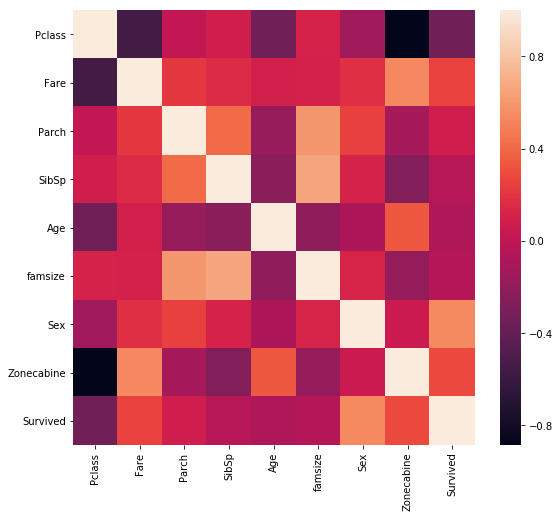

In [4]:
figure = plt.figure(figsize=(9,8))
corr = x_train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
corr
del(x_train['Survived'])

In [5]:
from sklearn import model_selection
from sklearn.feature_selection import RFECV
from sklearn import feature_selection

clf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=0,max_features='auto',min_samples_split=5)
clf.fit(x_train[:int((0.8*len(x_train)))], y_train[:int((0.8*len(x_train)))].values.ravel())
print(clf.feature_importances_)
pred = clf.predict(x_train[int((0.8*len(x_train))):])
accuracy_score(pred,y_train[int((0.8*len(x_train))):])

[0.07262801 0.20499107 0.03366989 0.03829683 0.16133103 0.05751907
 0.34233162 0.08923248]


0.8491620111731844

In [ ]:
#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'n_estimators': [1000],
              'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

tune_model = model_selection.GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = 3)
tune_model.fit(x_train, y_train.values.ravel())

print(' RandomF Parameters: ', tune_model.best_params_)
print(" RandomF Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print(" RandomF Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print(" RandomF Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

In [ ]:
RF_rfe = feature_selection.RFECV(clf, step = 1, scoring = 'accuracy', cv = 3)
RF_rfe.fit(x_train, y_train.values.ravel())
X_RF_rfe = x_train.columns.values[RF_rfe.get_support()]
rfe_results = model_selection.cross_validate(clf, x_train[X_RF_rfe], y_train.values.ravel(), cv  = 3)
print('AFTER DT RFE Training Shape New: ', x_train[X_RF_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_RF_rfe)
print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)